# Calculating Rates of Infection

### Data Sources
- NY Times COVID19 County-Level Data: https://github.com/nytimes/covid-19-data

### Goal
To calculate the following:
- Rate of infection per county in California
- Average weekly rate of infection for per county in California

### Outputs
The following data sets are generated from this notebook:
- Dates of available weekly data per county in California and corresponding week number
- Rates of infection per county in California
- Merged California COVID19 data and rate of infection per county in California
- Average weekly rate of infection for per county in California
- Number of increased cases per week per county in California

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

pd.options.display.max_rows = 200
%matplotlib inline

## Reading the data

In [2]:
# Reads the dataset from the NY Times source
covid = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv",
                    parse_dates=['date'])

# Previews the top five rows of the data
covid.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [3]:
# Previews the bottom five rows of the data
covid.tail()

,date,county,state,fips,cases,deaths
56536,2020-04-13,Sublette,Wyoming,56035.0,1,0
56537,2020-04-13,Sweetwater,Wyoming,56037.0,9,0
56538,2020-04-13,Teton,Wyoming,56039.0,56,0
56539,2020-04-13,Uinta,Wyoming,56041.0,4,0
56540,2020-04-13,Washakie,Wyoming,56043.0,4,0


In [4]:
# Filters out to California only
covid_ca = covid[covid.state=='California']

# Removes unknown counties
covid_ca = covid_ca[covid_ca.county!='Unknown']

print("Number of unique counties: ", covid_ca.county.nunique(), "\n")
print("California counties:")
print(covid_ca.county.unique())

Number of unique counties:  53 

California counties:
['Orange' 'Los Angeles' 'Santa Clara' 'San Francisco' 'San Diego'
 'Humboldt' 'Sacramento' 'Solano' 'Marin' 'Napa' 'Sonoma' 'Alameda'
 'Placer' 'San Mateo' 'Contra Costa' 'Yolo' 'Fresno' 'Madera' 'Riverside'
 'Santa Cruz' 'Shasta' 'San Joaquin' 'Ventura' 'Stanislaus' 'Tulare'
 'San Benito' 'San Luis Obispo' 'San Bernardino' 'Santa Barbara' 'Nevada'
 'Kern' 'Monterey' 'Mendocino' 'Amador' 'Imperial' 'Butte' 'El Dorado'
 'Siskiyou' 'Yuba' 'Calaveras' 'Merced' 'Mono' 'Inyo' 'Sutter' 'Colusa'
 'Kings' 'Glenn' 'Tuolumne' 'Alpine' 'Plumas' 'Del Norte' 'Tehama' 'Lake']


### Looking at which California counties are missing

In [5]:
california_counties = [
    'Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa',
    'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
    'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles',
    'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono',
    'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside',
    'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco',
    'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara',
    'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano',
    'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne',
    'Ventura', 'Yolo', 'Yuba']

In [6]:
# Counties missing in this data set
list(set(california_counties)-set(covid_ca.county.unique().tolist()))

['Sierra', 'Mariposa', 'Lassen', 'Trinity', 'Modoc']

## Plotting the data

Text(0.5, 1.0, 'Number of Cases in California Counties')

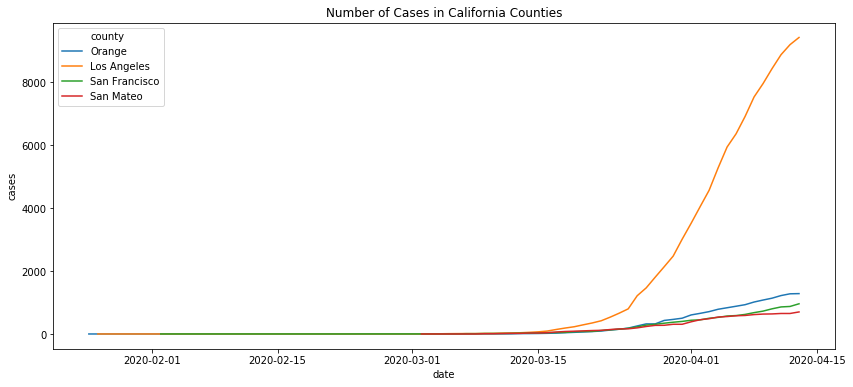

In [9]:
# Plotting SF, LA, Orange and San Mateo as an example
plt.figure(figsize=(14,6))

ax = sns.lineplot(x="date", y="cases", hue='county',
             data=covid_ca[covid_ca.county.isin(["San Francisco", "Los Angeles", "Orange", "San Mateo"])])
ax.set_title("Number of Cases in California Counties")

Text(0.5, 1.0, 'Number of Deaths in California Counties')

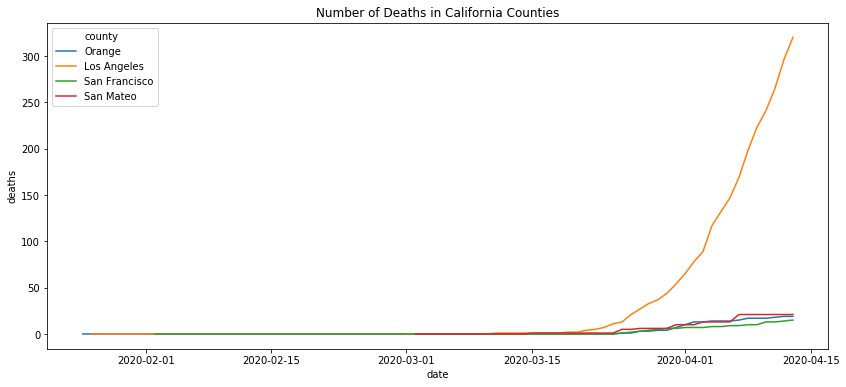

In [10]:
# Plotting SF, LA, Orange and San Mateo as an example
plt.figure(figsize=(14,6))

ax = sns.lineplot(x="date", y="deaths", hue='county',
             data=covid_ca[covid_ca.county.isin(["San Francisco", "Los Angeles", "Orange", "San Mateo"])])
ax.set_title("Number of Deaths in California Counties")

## Calculating rate of infection per county for California

In [11]:
def calculate_days(df, col):
    """
    To calculate the number of days since 01-01-2020 until each date listed on the data set.
    
    :param df: pd.DataFrame
    :param col: str, column name
    
    :return df: modified df with added day numbers
    """
    
    FMT = '%Y-%m-%d'  # date format 
    
    df_w_days = df.copy() # create copy of dataset

    df_w_days['day_no'] = df_w_days[col].astype(str).map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days + 1)
    return df_w_days


In [12]:
def calculate_rate_of_infection(df, state):
    """
    To calculate the rate of infection for each county in a given state.
    
    :param df: pd.DataFrame
    :param state: str, state name
    
    :return rates: pd.DataFrame with county names and rates
    """
    # Populates day numbers from calculate_days()
    df_w_days = calculate_days(df, "date")  
    
    # Creates an empty dictionary
    rates = {}

    counties = df[df.state==state].county.unique()

    # Removes unknown counties
    if 'Unknown' in counties:
        counties = counties[counties != 'Unknown']

    # Iterates through county list to find rates
    for county in counties:
        data = df_w_days.loc[df_w_days['county']==county] 
        x_data = list(data['day_no']) 
        y_data = list(data['cases']) 
        curve_fit = np.polyfit(x_data, np.log(y_data), 1) # fits exponential curve, finds rate
        rates[county] = curve_fit[0] # appends rate to dictionary
    
    # Converts rates dictionary to a DataFrame
    rates_df = pd.DataFrame.from_dict(rates, orient='index', 
                                      columns=['rate']).reset_index().rename({"index":"county"},axis=1)

    return rates_df

In [13]:
# Calculates rates of infection for California
calculate_rate_of_infection(covid, "California")

,county,rate
0,Orange,0.076537
1,Los Angeles,0.144768
2,Santa Clara,0.120184
3,San Francisco,0.106643
4,San Diego,0.156897
5,Humboldt,0.082291
6,Sacramento,0.141866
7,Solano,0.069453
8,Marin,0.141618
9,Napa,0.095721


In [14]:
# Saves rates into a DataFrame and outputs it as a CSV file
rates_df = calculate_rate_of_infection(covid, "California")
rates_df.to_csv("california_county_rates.csv", index=False)

In [15]:
# Merges rates and original California-only COVID19 DataFrames and prints a preview of the merged data
merged_data = pd.merge(covid_ca, rates_df, on='county')
merged_data.head()

,date,county,state,fips,cases,deaths,rate
0,2020-01-25,Orange,California,6059.0,1,0,0.076537
1,2020-01-26,Orange,California,6059.0,1,0,0.076537
2,2020-01-27,Orange,California,6059.0,1,0,0.076537
3,2020-01-28,Orange,California,6059.0,1,0,0.076537
4,2020-01-29,Orange,California,6059.0,1,0,0.076537


In [16]:
# Saves the merged rates and COVID19 data as a CSV file
merged_data.to_csv("cases_and_rate.csv", index=False)

In [17]:
# Sanity check - Prints the number of rows and columns for the COVID19 DataFrame and the merged data
print("**'Original' COVID19 data set size (rows, cols):\t", covid_ca.shape)
print("Merged COVID19 and rates data size (rows, cols):\t", merged_data.shape)

print("\n**'Original' refers to California-only COVID19 data excluding the 'Unknown' county.")

**'Original' COVID19 data set size (rows, cols):	 (1819, 6)
Merged COVID19 and rates data size (rows, cols):	 (1819, 7)

**'Original' refers to California-only COVID19 data excluding the 'Unknown' county.


## Predicting the average rate of infection per county

In [18]:
def calculate_avg_weekly_rate_of_infection(df, state):
    """
    To calculate the average weekly rate of infection for each county in a given state.
    
    :param df: pd.DataFrame
    :param state: str, state name
    
    :return rates: pd.DataFrame with county names, average weekly rates and week numbers
    """
    # Create empty dictionaries
    avg_after = {}
    avg_before = {}

    # Creates empty resulting DataFrame
    weekly_rates_all = pd.DataFrame(columns=['county', 'weekly_rate', 'week_no'])

    counties = df[df.state==state].county.unique()

    # Removes unknown counties
    if 'Unknown' in counties:
        counties = counties[counties != 'Unknown']

    # Iterates through county list
    for county in counties:
        data = df.loc[df['county']==county] 
        data = data.sort_values(by=['date']) # sort data by date
        data['date_nums'] = data.reset_index().index+1 # re-label dates to use as x-variable
        x_data = list(data['date_nums']) 
        y_data = list(data['cases']) 
        curve_fit = np.polyfit(x_data, np.log(y_data), 1) # fit exponential curve, find rate

        # Add values to dictionary
        exp_rate = curve_fit[0]
        intercept = curve_fit[1]

        # Predicts 7 days out
        end_next_week_cases = np.exp(intercept) * np.exp(exp_rate * (x_data[-1]+7)) # projected number of cases for end of week
        current_cases = y_data[-1] # num of cases today (or latest num of cases)
        avg_next_week_rate = (end_next_week_cases - current_cases) / 7 # projected rate for next week

        # Predicts current week
        if (len(x_data)//7) >= 1:
            # Checks that data for past week exists
            beg_current_week_cases = y_data[-7]
            avg_current_rate = (current_cases - beg_current_week_cases) / 7
        else:
            avg_current_rate = 0
        past_weekly_rates = {}
        
        # As of today, which is 04/15, the latest week is week 16, starting on 04/13
        latest_week = 16  

        # Predicts previous weeks
        weeks = data.groupby(['county', pd.Grouper(key='date', freq='W-MON')]).max().reset_index().date.dt.week
        beg_week_cases = []
        end_week_cases = []
        avg_rates = []

        # Iterates through each week in the county
        for wk in weeks:
            end_case = data[(data.county==county)&(data.date.dt.week==wk)].tail(1).cases.values[0]
            end_week_cases += [end_case]
            beg_case = data[(data.county==county)&(data.date.dt.week==wk)].head(1).cases.values[0]
            beg_week_cases += [beg_case]
        # Creates an average rate based on the difference in cases for each county
        for end_case, beg_case in zip(end_week_cases, beg_week_cases):
            single_rate = (end_case - beg_case) / 7
            avg_rates += [single_rate]
        
        # Converts rates dictionary to a DataFrame and appends to resulting DataFrame
        weekly_rates_df = pd.DataFrame({"county":county, "weekly_rate": avg_rates, "week_no": weeks})

        weekly_rates_all = pd.concat([weekly_rates_all, weekly_rates_df], ignore_index=True, sort=False)
    weekly_rates_all = weekly_rates_all.sort_values(['county', 'week_no'])

    return weekly_rates_all


In [19]:
# Calculates the average weekly rate of infection for counties in California
avg_weekly_rate_of_infection = calculate_avg_weekly_rate_of_infection(covid_ca, 'California')

# Previews the top 20 rows
avg_weekly_rate_of_infection.head(20)

,county,weekly_rate,week_no
101,Alameda,0.285714,10
102,Alameda,1.857143,11
103,Alameda,12.428571,12
104,Alameda,21.714286,13
105,Alameda,40.428571,14
106,Alameda,36.428571,15
107,Alameda,0.000000,16
272,Alpine,0.000000,14
273,Alpine,0.000000,15
274,Alpine,0.000000,16


In [20]:
# Saves the average weekly rates per county in California as a CSV file
avg_weekly_rate_of_infection.to_csv("avg_weekly_rate_of_infection.csv", index=False)

## Calculating the starting date for each week and the corresponding week number for each county in California

In [30]:
# Calculates each county's first date for each week and its week number
county_starting_dates_and_week_no = covid_ca.groupby(['county', pd.Grouper(key='date', freq='W-MON')]).min().reset_index()[['county','date']]
county_starting_dates_and_week_no['week'] = county_starting_dates_and_week_no.date.dt.week

# Previews the top 20 rows
county_starting_dates_and_week_no.head(20)

,county,date,week
0,Alameda,2020-03-02,10
1,Alameda,2020-03-09,11
2,Alameda,2020-03-16,12
3,Alameda,2020-03-23,13
4,Alameda,2020-03-30,14
5,Alameda,2020-04-06,15
6,Alameda,2020-04-13,16
7,Alpine,2020-03-30,14
8,Alpine,2020-04-06,15
9,Alpine,2020-04-13,16


## Calculating the number of new cases on a weekly basis per county in California

In [32]:
# Calculates the number of cases in the last day of each week and the weekly difference of total number of cases
weekly_case_increase = covid_ca.groupby(['county', pd.Grouper(key='date', freq='W-MON')]).max().reset_index()[['county','date','cases','deaths']].rename({"cases":"ending_cases", "deaths":"ending_deaths"},axis=1)
weekly_case_increase['case_increase'] = weekly_case_increase.groupby(['county']).ending_cases.diff()
weekly_case_increase.loc[weekly_case_increase.case_increase.isnull(),"case_increase"] = weekly_case_increase[weekly_case_increase.case_increase.isnull()].ending_cases

# Brings in week number
weekly_case_increase = pd.merge(weekly_case_increase, county_starting_dates_and_week_no, on=['county','date'])

# Previews the top 30 rows
weekly_case_increase.head(30)

,county,date,ending_cases,ending_deaths,case_increase,week
0,Alameda,2020-03-02,1,0,1.0,10
1,Alameda,2020-03-09,24,0,23.0,11
2,Alameda,2020-03-16,40,0,16.0,12
3,Alameda,2020-03-23,139,1,99.0,13
4,Alameda,2020-03-30,304,7,165.0,14
5,Alameda,2020-04-06,609,13,305.0,15
6,Alameda,2020-04-13,907,23,298.0,16
7,Alpine,2020-03-30,1,0,1.0,14
8,Alpine,2020-04-06,2,0,1.0,15
9,Alpine,2020-04-13,2,0,0.0,16


In [33]:
# Saves the weekly ending number of cases and deaths, and the weekly case increase per county in California as a CSV file
weekly_case_increase.to_csv("weekly_case_increase.csv", index=False)
